In [70]:
!pip install transformers

In [71]:
!pip install -q datasets

In [72]:
!pip install pyyaml==5.1
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


In [73]:
from datasets import load_dataset 

datasets = load_dataset("katanaml/cord")

Reusing dataset cord (/root/.cache/huggingface/datasets/katanaml___cord/cord/1.0.0/fa0960248a7d19cf19675785d5d3dd9eab83b4aea9274b97943d534be56d8a91)


  0%|          | 0/3 [00:00<?, ?it/s]

In [74]:
labels = datasets['train'].features['ner_tags'].feature.names
print(labels)

['O', 'I-menu.cnt', 'I-menu.discountprice', 'I-menu.nm', 'I-menu.num', 'I-menu.price', 'I-menu.sub_cnt', 'I-menu.sub_nm', 'I-menu.sub_price', 'I-menu.unitprice', 'I-sub_total.discount_price', 'I-sub_total.etc', 'I-sub_total.service_price', 'I-sub_total.subtotal_price', 'I-sub_total.tax_price', 'I-total.cashprice', 'I-total.changeprice', 'I-total.creditcardprice', 'I-total.emoneyprice', 'I-total.menuqty_cnt', 'I-total.menutype_cnt', 'I-total.total_etc', 'I-total.total_price']


In [75]:
example = datasets["validation"][0]
print(example.keys())

dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image_path'])


In [76]:
print(example['words'])

['1', 'REAL', 'GANACHE', '16,500', '1', 'EGG', 'TART', '13,000', '1', 'PIZZA', 'TOAST', '16,000', 'TOTAL', '45,500', 'CASH', '50,000', 'CHANGE', '4,500']


In [77]:
print(example['bboxes'])

[[203, 429, 224, 452], [233, 427, 307, 452], [314, 427, 430, 452], [671, 425, 768, 450], [203, 455, 224, 478], [236, 453, 291, 478], [298, 453, 370, 476], [671, 452, 768, 476], [203, 481, 224, 504], [233, 479, 324, 504], [331, 478, 416, 503], [671, 478, 770, 501], [231, 529, 402, 577], [576, 527, 775, 575], [233, 575, 307, 600], [671, 570, 773, 594], [225, 601, 437, 642], [606, 595, 777, 643]]


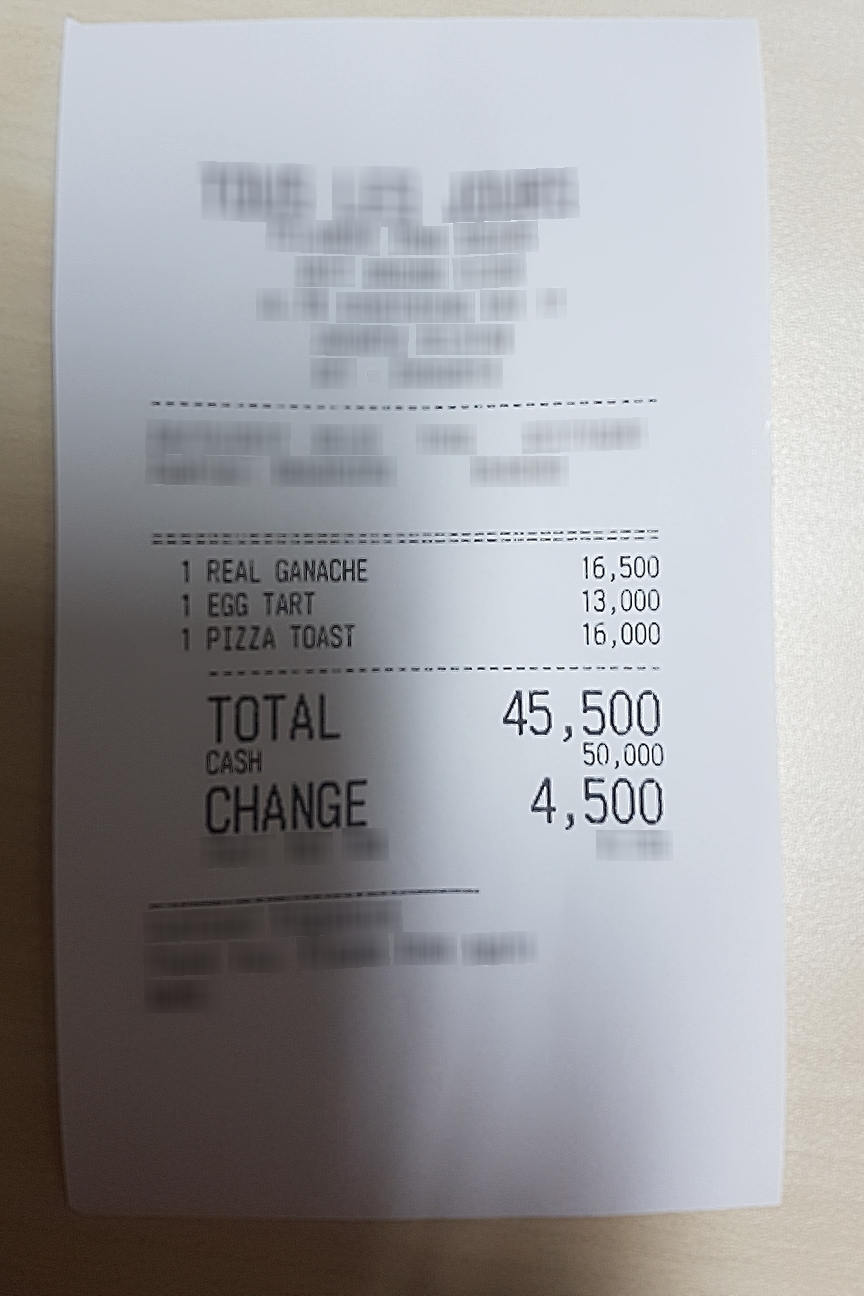

In [78]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(example['image_path'])
image = image.convert("RGB")
image

In [79]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

encoded_inputs = processor(image, example['words'], boxes=example['bboxes'], return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoded_inputs.pop('offset_mapping')

In [80]:
encoded_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])

In [81]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(device)

In [82]:
from transformers import LayoutLMv2ForTokenClassification

# load the fine-tuned model from the hub
model = LayoutLMv2ForTokenClassification.from_pretrained("katanaml/layoutlmv2-finetuned-cord")
id2label = model.config.id2label
model.to(device)

# forward pass
outputs = model(**encoded_inputs)
print(outputs.logits.shape)

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:779: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:789: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

torch.Size([1, 34, 23])


In [83]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

In [84]:
processor.tokenizer.batch_decode(encoded_inputs.input_ids)

['[CLS] 1 real ganache 16, 500 1 egg tart 13, 000 1 pizza toast 16, 000 total 45, 500 cash 50, 000 change 4, 500 [SEP]']

In [85]:
import numpy as np

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

In [86]:
for word in example['words']:
  print(word)

1
REAL
GANACHE
16,500
1
EGG
TART
13,000
1
PIZZA
TOAST
16,000
TOTAL
45,500
CASH
50,000
CHANGE
4,500


In [87]:
print(true_predictions)

['I-menu.nm', 'I-menu.cnt', 'I-menu.nm', 'I-menu.nm', 'I-menu.price', 'I-menu.cnt', 'I-menu.nm', 'I-menu.nm', 'I-menu.price', 'I-menu.cnt', 'I-menu.nm', 'I-menu.nm', 'I-menu.price', 'I-total.total_price', 'I-total.total_price', 'I-total.cashprice', 'I-total.cashprice', 'I-total.changeprice', 'I-total.changeprice', 'I-menu.cnt']


In [88]:
for prediction in true_predictions:
  print(prediction)

I-menu.nm
I-menu.cnt
I-menu.nm
I-menu.nm
I-menu.price
I-menu.cnt
I-menu.nm
I-menu.nm
I-menu.price
I-menu.cnt
I-menu.nm
I-menu.nm
I-menu.price
I-total.total_price
I-total.total_price
I-total.cashprice
I-total.cashprice
I-total.changeprice
I-total.changeprice
I-menu.cnt


In [89]:
for box in true_boxes:
  print(box)

[0.0, 0.0, 0.0, 0.0]
[175.39200000000002, 555.984, 193.536, 585.792]
[201.312, 553.3919999999999, 265.248, 585.792]
[271.296, 553.3919999999999, 371.52, 585.792]
[579.744, 550.8, 663.552, 583.2]
[175.39200000000002, 589.6800000000001, 193.536, 619.4879999999999]
[203.904, 587.088, 251.42399999999998, 619.4879999999999]
[257.472, 587.088, 319.68, 616.896]
[579.744, 585.792, 663.552, 616.896]
[175.39200000000002, 623.376, 193.536, 653.184]
[201.312, 620.784, 279.93600000000004, 653.184]
[285.98400000000004, 619.4879999999999, 359.424, 651.888]
[579.744, 619.4879999999999, 665.28, 649.296]
[199.584, 685.5840000000001, 347.32800000000003, 747.7919999999999]
[497.664, 682.9920000000001, 669.6, 745.1999999999999]
[201.312, 745.1999999999999, 265.248, 777.6]
[579.744, 738.7199999999999, 667.8720000000001, 769.824]
[194.4, 778.896, 377.568, 832.032]
[523.584, 771.12, 671.328, 833.328]
[864.0, 1296.0, 864.0, 1296.0]


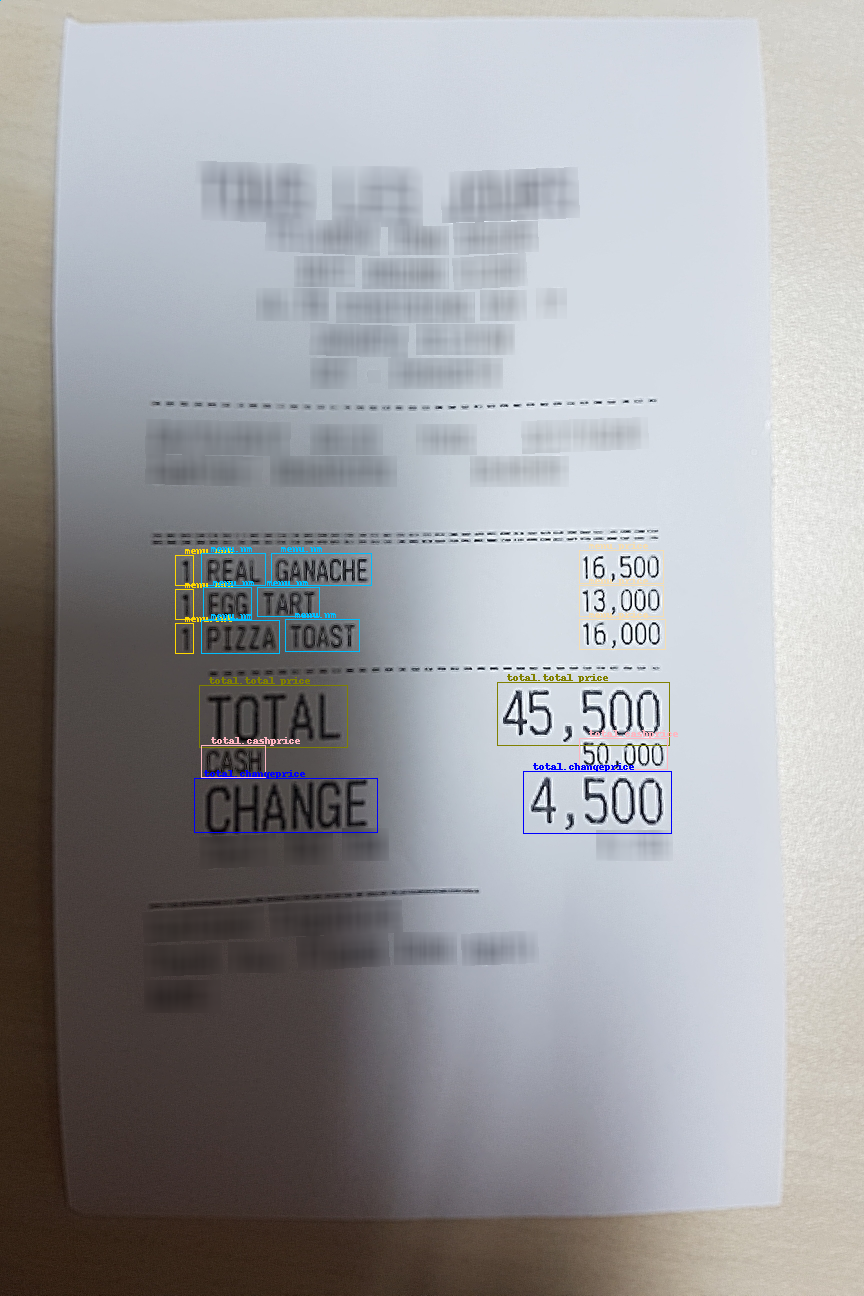

In [90]:
from PIL import ImageDraw
import numpy as np
import PIL

image = Image.open(example['image_path'])
image = image.convert("RGB")

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'o'
    return label

label_ints = np.random.randint(0,len(PIL.ImageColor.colormap.items()),30)

label_color_pil = [k for k,_ in PIL.ImageColor.colormap.items()]
	
label_color = [label_color_pil[i] for i in label_ints]
label2color = {}
for k,v in id2label.items():
  if v[2:] == '':
    label2color['o']=label_color[k]
  else:
    label2color[v[2:]]=label_color[k]

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

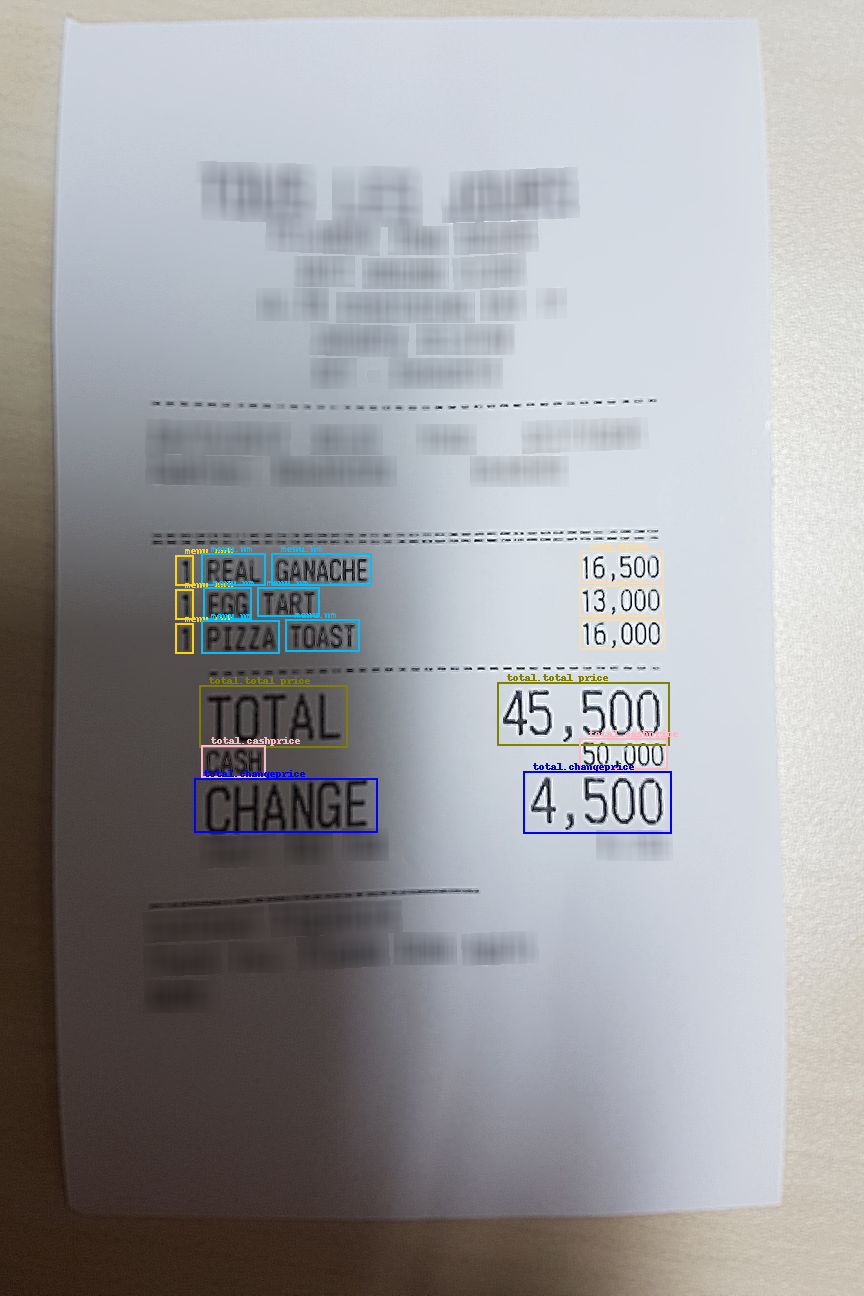

In [91]:
# Compare this to the ground truth

image = Image.open(example['image_path'])
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['words'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image